# The dojo

## Setup training device

In [1]:
!nvidia-smi

Fri Mar 24 12:02:01 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.29                 Driver Version: 531.29       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080       WDDM | 00000000:01:00.0  On |                  N/A |
| 53%   40C    P5               40W / 340W|   2652MiB / 10240MiB |     28%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch
from torch import device, nn
import torchvision
import torchvision.io as io

torch.manual_seed(42)

print(f'PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}')

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using device: {device}')

ok = io.read_image("data/E45Vejle_1011.jpg")

PyTorch version: 2.0.0+cu118
torchvision version: 0.15.1+cu118
Using device: cuda


## Data loading

### Using chromecut to prepare datasets

In [3]:
from dataset import chromeCutter

chromeCutter("data/leftImg8bit/indices/trainIndex/bremen.csv","data/leftImg8bit/train/bremen/", "bremenCut", "train")
chromeCutter("data/leftImg8bit/indices/testIndex/berlin.csv","data/leftImg8bit/test/berlin/", "berlinCut", "test")



### Custom dataset

In [4]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [5]:
from torch.utils.data import DataLoader
from dataset import CustomImageDataset
from torchvision import transforms

train_data = CustomImageDataset("data/leftImg8bit/indices/trainIndex/bremenCut.csv","data/leftImg8bit/train/cut/bremenCut", transform=train_transforms)
test_data = CustomImageDataset("data/leftImg8bit/indices/testIndex/berlinCut.csv","data/leftImg8bit/test/cut/berlinCut", transform=train_transforms)

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

print(f'Len of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}')
print(f'Len of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}')

Len of train dataloader: 93 batches of 32
Len of test dataloader: 230 batches of 32


##### Check out what's inside the training dataloader

In [6]:
train_features_batch = next(iter(train_dataloader))

print(F"Train features shape: {train_features_batch.shape}")

Train features shape: torch.Size([32, 3, 64, 64])


## Model

### Create a flatten layer - Testing Flatten()

In [7]:
flatten_model = nn.Flatten()

x = train_features_batch[0]
print(f'Shape before flattening: {x.shape}')     # torch.Size([3, 1024, 2048])

output = flatten_model(x)
print(f'Shape after flattening: {output.shape}') # torch.Size([3, 2097152])

Shape before flattening: torch.Size([3, 64, 64])
Shape after flattening: torch.Size([3, 4096])


#### MoCo

In [8]:
from model.chrome_vision import ChromeCut
from model.encoder import ResNet50
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet50_Weights

encoder = models.resnet50(weights=ResNet50_Weights.DEFAULT)

IN_FEATURES = encoder.fc.in_features = 2048 # 2097152
OUT_FEATURES = encoder.fc.out_features = 10
encoder.fc = nn.Linear(IN_FEATURES, OUT_FEATURES)

model = ChromeCut(base_encoder=encoder,
                  feature_dim=OUT_FEATURES,
                  queue_size=65000,
                  momentum=0.9,
                  softmax_temp=0.07,
                  mlp=True).to(device)

### Setup loss function and optimizer

In [9]:
loss_fn = nn.CrossEntropyLoss()

# lr smaller than 0.001
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)

### Training loop - MoCo

  0%|          | 0/7 [00:00<?, ?it/s]


	Epoch: 0



  0%|          | 0/93 [00:00<?, ?it/s]

Train loss: 8.16184 | Train acc1: 0.00% | Train acc5: 1.08%

	Epoch: 1



  0%|          | 0/93 [00:00<?, ?it/s]

Train loss: 7.85812 | Train acc1: 0.00% | Train acc5: 1.08%

	Epoch: 2



  0%|          | 0/93 [00:00<?, ?it/s]

Train loss: 8.05786 | Train acc1: 0.00% | Train acc5: 0.00%

	Epoch: 3



  0%|          | 0/93 [00:00<?, ?it/s]

Train loss: 8.26152 | Train acc1: 0.00% | Train acc5: 1.08%

	Epoch: 4



  0%|          | 0/93 [00:00<?, ?it/s]

Train loss: 8.07406 | Train acc1: 0.00% | Train acc5: 0.00%

	Epoch: 5



  0%|          | 0/93 [00:00<?, ?it/s]

Train loss: 8.21066 | Train acc1: 0.00% | Train acc5: 0.00%

	Epoch: 6



  0%|          | 0/93 [00:00<?, ?it/s]

Train loss: 8.24928 | Train acc1: 0.00% | Train acc5: 0.00%
Train time on cuda:0: 58.025 seconds


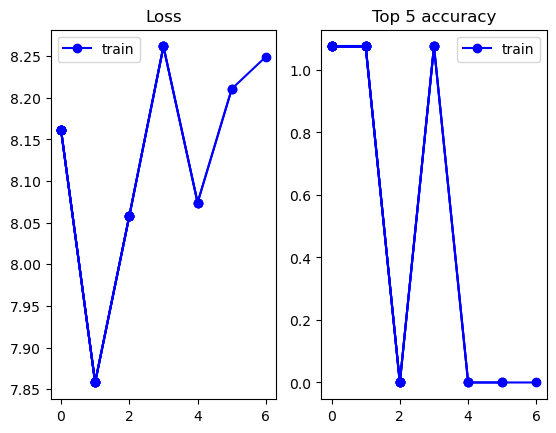

In [11]:
from timeit import default_timer as timer
from tqdm.auto import tqdm
from model.evaluation import train_step, test_step # use torchmetrics.utilities.data.select_topk
from model.utilis import print_train_time, accuracy_top_k
import matplotlib.pyplot as plt
import os
import cv2

y_loss = {}  # loss history
y_loss['train'] = []
y_loss['val'] = []
top5_rate = {}
top5_rate['train'] = []
top5_rate['val'] = []

x_epoch = []

fig = plt.figure()
ax0 = fig.add_subplot(121, title="Loss")
ax1 = fig.add_subplot(122, title="Top 5 accuracy")

def draw_curve(current_epoch):
    x_epoch.append(current_epoch)
    ax0.plot(x_epoch, torch.Tensor(y_loss['train']), 'bo-', label='train')
    # ax0.plot(x_epoch, y_loss['val'], 'ro-', label='val')
    ax1.plot(x_epoch, top5_rate['train'], 'bo-', label='train')
    # ax1.plot(x_epoch, y_err['val'], 'ro-', label='val')
    if current_epoch == 0:
        ax0.legend()
        ax1.legend()
    fig.savefig(os.path.join('./lossGraphs', 'train.jpg'))
running_loss = 0.0
running_corrects = 0.0

train_time_start_on_cpu = timer()

epochs = 7
for epoch in tqdm(range(epochs)):
    print(f'\n\tEpoch: {epoch}\n')

    (loss, top5) = train_step(model=model,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_top_k,
               device=device)
    # test_step(model=model,
    #            data_loader=test_dataloader,
    #            loss_fn=loss_fn,
    #            accuracy_fn=accuracy_top_k,
    #            device=device)    
    y_loss["train"].append(loss)
    top5_rate["train"].append(top5)
    draw_curve(epoch)
# Print time taken
if epoch > 5:
    img = cv2.imread('lossGraphs/train.jpg')
    cv2.imshow("Loss and accuracy", img)
    cv2.setWindowProperty("Loss and accuracy", cv2.WND_PROP_TOPMOST, 1) #Forces window on top
    cv2.waitKey(0)
    cv2.destroyAllWindows()
train_time_end_on_cpu = timer()
total_train_time_model = print_train_time(train_time_start_on_cpu, train_time_end_on_cpu, str(next(model.parameters()).device))

### Training loop - For testing CPU and GPU (do not change)

### Calculate model results on test dataset

In [ ]:
model_results = test_step(model=model,
                           data_loader=test_dataloader,
                           loss_fn=loss_fn,
                           accuracy_fn=accuracy_top_k,
                           device=device)

model_results